Dans ce notebook on procede a l'extraction de feature des epochs des experiences de screening.

In [1]:
import mne
import numpy as np
import os
import scipy.signal
from numpy import linalg
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mne.time_frequency import psd_array_multitaper
from neurodsp.timefrequency import amp_by_time
import neurodsp


extraction des données et on les reformes pour simplifier les demarches après.

In [2]:

file_path = r"C:\Users\phili\EEG_project\EEG_proj_data\ucsd-neural-data-challenge\data\epoch_propre\screening_epochs_epo.fif"
epochs = mne.read_epochs(file_path)
sample_rate = epochs.info['sfreq']
win_start, win_end = int(0 * sample_rate), int(4 * sample_rate)  
event_codes = epochs.events[:, 2]  

trials = {f"event_{code}": [] for code in np.unique(event_codes)}


for code in np.unique(event_codes):
    event_indices = np.where(event_codes == code)[0]
    sliced_epochs = [
        epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
    ]
    trials[f"event_{code}"] = np.transpose(np.array(sliced_epochs), (1, 2, 0))


Reading C:\Users\phili\EEG_project\EEG_proj_data\ucsd-neural-data-challenge\data\epoch_propre\screening_epochs_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 3) active
    Found the data of interest:
        t =       0.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
2240 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\phili\AppData\Local\Temp\ipykernel_19680\2115927525.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
C:\Users\phili\AppData\Local\Temp\ipykernel_19680\2115927525.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
C:\Users\phili\AppData\Local\Temp\ipykernel_19680\2115927525.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
C:\Users\phili\AppData\Local\Temp\ipykernel_19680\2115927525.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of co

Suivant le processus de cette étude: Blankertz B, Dornhege G, Krauledat M, Müller KR, Curio G. The non-invasive Berlin Brain-Computer Interface: fast acquisition of effective performance in untrained subjects. Neuroimage. 2007 Aug 15;37(2):539-50. doi: 10.1016/j.neuroimage.2007.01.051. Epub 2007 Mar 1. PMID: 17475513. On va utiliser le logarithme de la variance des signaux de fréquence précise comme features pour notre classifieur. 

Pour les fréquences, en se basant sur la littérature, on utilise de 8 à 15 ce qui correspond à la fréquence alpha impliqué largement dans les experience d'imagerie motrice.

In [3]:

# création du filtre 
def bandpass(trials, lo, hi, sample_rate, nchannels=3):
    """
    Applies a bandpass filter to the first `nchannels` in the EEG data.
    
    Parameters:
    - trials: 3D array (channels x samples x trials), EEG data
    - lo, hi: Lower and upper bounds of the filter (in Hz)
    - sample_rate: Sampling frequency of the data (Hz)
    - nchannels: Number of channels to filter (default: 3)

    Returns:
    - trials_filt: Bandpass-filtered EEG data (channels x samples x trials)
    """
    b, a = scipy.signal.iirfilter(6, [lo / (sample_rate / 2), hi / (sample_rate / 2)], btype='band')

    trials_filt = trials[:nchannels].copy() 
    for trial in range(trials.shape[2]):  
        for ch in range(nchannels): 
            trials_filt[ch, :, trial] = scipy.signal.filtfilt(b, a, trials[ch, :, trial])
    return trials_filt

trials_filt = {
    'event_0': bandpass(trials['event_0'], lo=8, hi=15, sample_rate=sample_rate),
    'event_1': bandpass(trials['event_1'], lo=8, hi=15, sample_rate=sample_rate),
}
print(f"Shape of filtered trials for 'event_0': {trials_filt['event_0'].shape}")
print(f"Shape of filtered trials for 'event_1': {trials_filt['event_1'].shape}")

cl1 = 'event_0'
cl2 = 'event_1'


Shape of filtered trials for 'event_0': (3, 1000, 1120)
Shape of filtered trials for 'event_1': (3, 1000, 1120)


Dans cette pipeline on utilise un filtre CSP (Common Spatial Pattern), pour transformer nos donnés d'epoch brut. Le processus consiste à calculer la matrice de covariance des données pour chaque classe, puis à appliquer une normalisation pour rendre les données adaptées à la méthode CSP. Cette méthode permet de transformer les signaux de chaque classe en un espace commun, en maximisant la séparation des signaux. Ensuite, la variance logarithmique est calculée pour chaque canal afin d'évaluer la variabilité des signaux après la transformation CSP.

In [4]:
def logvar(trials):
    return np.log(np.var(trials, axis=1))


def batch_cov(trials, batch_size=50):
    n_trials = trials.shape[2]
    n_channels = trials.shape[0]

    cov_sum = np.zeros((n_channels, n_channels))

    for start in range(0, n_trials, batch_size):
        end = min(start + batch_size, n_trials)
        batch = trials[:, :, start:end]
        for i in range(batch.shape[2]):
            cov_sum += np.cov(batch[:, :, i], rowvar=True)

    return cov_sum / n_trials

def whitening(sigma):
    
    U, l, _ = linalg.svd(sigma)
    return U @ np.diag(l ** -0.5)

def csp(trials_r, trials_l):
    cov_r = batch_cov(trials_r)
    cov_l = batch_cov(trials_l)
    P = whitening(cov_r + cov_l) 
    B, _, _ = linalg.svd(P.T @ cov_l @ P)
    W = P @ B
    return W

def apply_csp(W, trials):
  
    n_trials = trials.shape[2]
    trials_csp = np.zeros((W.shape[0], trials.shape[1], n_trials))
    for i in range(n_trials):
        trials_csp[:, :, i] = W.T @ trials[:, :, i]
    return trials_csp

cl1 = 'event_0'  
cl2 = 'event_1'  

W = csp(trials_filt[cl1], trials_filt[cl2])

trials_csp = {
    cl1: apply_csp(W, trials_filt[cl1]),
    cl2: apply_csp(W, trials_filt[cl2])
}

trials_logvar_csp = {
    cl1: logvar(trials_csp[cl1]),
    cl2: logvar(trials_csp[cl2])
}

for class_label, logvar_data in trials_logvar_csp.items():
    print(f"Shape of log variance for class {class_label}: {logvar_data.shape}")

Shape of log variance for class event_0: (3, 1120)
Shape of log variance for class event_1: (3, 1120)


normalisation puis on creer un dataframe

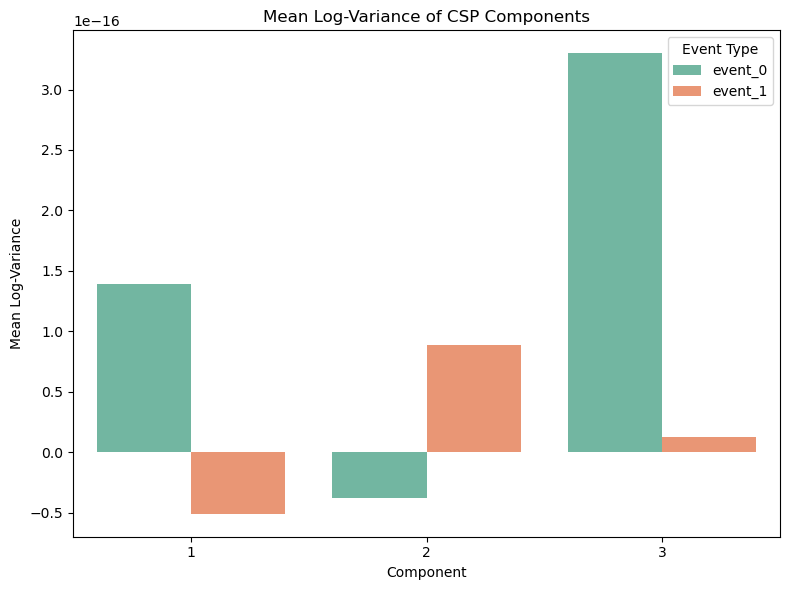

,Event Type,Epoch,eeg comp 1,eeg comp 2,eeg comp 3
0,0,0,0.734911,0.556960,1.614376
1,0,1,-0.699372,-0.434038,-0.039200
2,0,2,-0.345019,-0.230283,0.075464
3,0,3,0.362070,0.134338,0.032106
4,0,4,0.014610,-0.197126,0.276047


In [5]:

def normalize_features(features):
    
    mean = np.mean(features, axis=1, keepdims=True)  
    std = np.std(features, axis=1, keepdims=True)    
    return (features - mean) / std

trials_logvar_normalized = {
    'event_0': normalize_features(trials_logvar_csp['event_0']),
    'event_1': normalize_features(trials_logvar_csp['event_1']),
}

data = [
    [event_type, comp + 1, np.mean(trials_logvar_normalized[event_type][comp, :])]
    for event_type in ['event_0', 'event_1']
    for comp in range(3)
]

df = pd.DataFrame(data, columns=['Event Type', 'Component', 'Log-Variance'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Component', y='Log-Variance', hue='Event Type', data=df, palette='Set2')

plt.title('Mean Log-Variance of CSP Components')
plt.xlabel('Component')
plt.ylabel('Mean Log-Variance')
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

data = [
    [event_type, comp + 1, epoch, logvar_data[comp, epoch]]
    for event_type in [0, 1]
    for epoch in range(trials_logvar_normalized[f'event_{event_type}'].shape[1])
    for comp in range(3)
    for logvar_data in [trials_logvar_normalized[f'event_{event_type}']]
]

df = pd.DataFrame(data, columns=['Event Type', 'Component', 'Epoch', 'Log-Variance'])
eeg_df_pivoted = df.pivot_table(index=['Event Type', 'Epoch'], columns='Component', values='Log-Variance').reset_index()
eeg_df_pivoted.columns = ['Event Type', 'Epoch', 'eeg comp 1', 'eeg comp 2', 'eeg comp 3']
eeg_df_pivoted['Epoch'] = range(len(eeg_df_pivoted))

eeg_df_pivoted.head()

Dans certaines études, cette pipeline uniquement permet de classifier efficacement les IM. Cependant dans notre cas nous n'avons que 3 canaux ce qui nous empeche de trouver des résultats claires seulement à partir de ces features. 

On va donc utiliser la densité spectrale de puissance (psd). En effectuant une transformer de fourrier on peut observer comment la puissance d'un signal est distribuée en fonction de la fréquence. En l'occurence on a observé dess fortes différences dans les psd dans notre visualisation en fonction de l'IM (alpha et beta). 

On va proceder à un prcessus similaire, en utilsant la transformation en premier.

In [6]:
epochs = mne.read_epochs(file_path)

sample_rate = epochs.info['sfreq']
win_start, win_end = int(0 * sample_rate), int(4 * sample_rate) 
event_codes = epochs.events[:, 2]

trials = {f"event_{code}": [] for code in np.unique(event_codes)}

for code in np.unique(event_codes):
    event_indices = np.where(event_codes == code)[0]
    sliced_epochs = [
        epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
    ]
    trials[f"event_{code}"] = np.transpose(np.array(sliced_epochs), (1, 2, 0))

for event, data in trials.items():
    print(f"Shape of {event}: {data.shape}")

trials_filt = {
    'event_0': bandpass(trials['event_0'], lo=8, hi=30, sample_rate=sample_rate),
    'event_1': bandpass(trials['event_1'], lo=8, hi=30, sample_rate=sample_rate),
}

Reading C:\Users\phili\EEG_project\EEG_proj_data\ucsd-neural-data-challenge\data\epoch_propre\screening_epochs_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 3) active
    Found the data of interest:
        t =       0.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
2240 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\phili\AppData\Local\Temp\ipykernel_19680\2965051158.py:12: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
C:\Users\phili\AppData\Local\Temp\ipykernel_19680\2965051158.py:12: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
C:\Users\phili\AppData\Local\Temp\ipykernel_19680\2965051158.py:12: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
C:\Users\phili\AppData\Local\Temp\ipykernel_19680\2965051158.py:12: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of co

Shape of event_0: (6, 1000, 1120)
Shape of event_1: (6, 1000, 1120)


In [7]:


cl1 = 'event_0'
cl2 = 'event_1'

def psd(trials, sfreq, fmin=1, fmax=40):
    
    ntrials = trials.shape[2] 
    n_channels = 3  
    
    
    trials_PSD = np.zeros((n_channels, 157, ntrials))  
    
    for trial in range(ntrials):
        for ch in range(n_channels):  
            eeg_data = trials[ch, :, trial]
            
            psd, freqs = psd_array_multitaper(eeg_data, sfreq=sfreq, fmin=fmin, fmax=fmax, adaptive=False, normalization='full')
            
            trials_PSD[ch, :, trial] = psd  
            
    return trials_PSD, freqs

sfreq = 250  

psd_r, freqs = psd(trials['event_0'], sfreq=sfreq)  

psd_l, freqs = psd(trials['event_1'], sfreq=sfreq) 

trials_PSD = {'event_0': psd_r, 'event_1': psd_l}

psd_r_filt, freqs = psd(trials_filt[cl1], sfreq=sfreq) 
psd_l_filt, _ = psd(trials_filt[cl2], sfreq=sfreq)      

trials_PSD_filt = {cl1: psd_r_filt, cl2: psd_l_filt}


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

In [8]:

def batch_cov(trials, batch_size=50):
    n_trials = trials.shape[2]
    n_channels = trials.shape[0]

    cov_sum = np.zeros((n_channels, n_channels))

    for start in range(0, n_trials, batch_size):
        end = min(start + batch_size, n_trials)
        batch = trials[:, :, start:end]
        for i in range(batch.shape[2]):
            cov_sum += np.cov(batch[:, :, i], rowvar=True)

    n_batches = (n_trials + batch_size - 1) // batch_size  
    return cov_sum / n_batches

def whitening(sigma, epsilon=1e-6):
    U, l, _ = linalg.svd(sigma + epsilon * np.eye(sigma.shape[0]))  
    return U @ np.diag(l ** -0.5)

def csp(trials_r, trials_l):
    cov_r = batch_cov(trials_r)
    cov_l = batch_cov(trials_l)
    P = whitening(cov_r + cov_l)  
    _, _, Vt = linalg.svd(P.T @ cov_l @ P)
    W = P @ Vt.T  
    return W

def apply_csp(W, trials):
    n_trials = trials.shape[2]
    trials_csp = np.zeros((W.shape[0], trials.shape[1], n_trials))
    for i in range(n_trials):
        trials_csp[:, :, i] = W.T @ trials[:, :, i]
    return trials_csp


W = csp(trials_PSD_filt['event_0'], trials_PSD_filt['event_1'])  
trials_csp = {
    'event_0': apply_csp(W, trials_PSD_filt['event_0']),
    'event_1': apply_csp(W, trials_PSD_filt['event_1'])   
}

trials_logvar_csp_psd = {
    'event_0': logvar(trials_csp['event_0']),
    'event_1': logvar(trials_csp['event_1'])
}


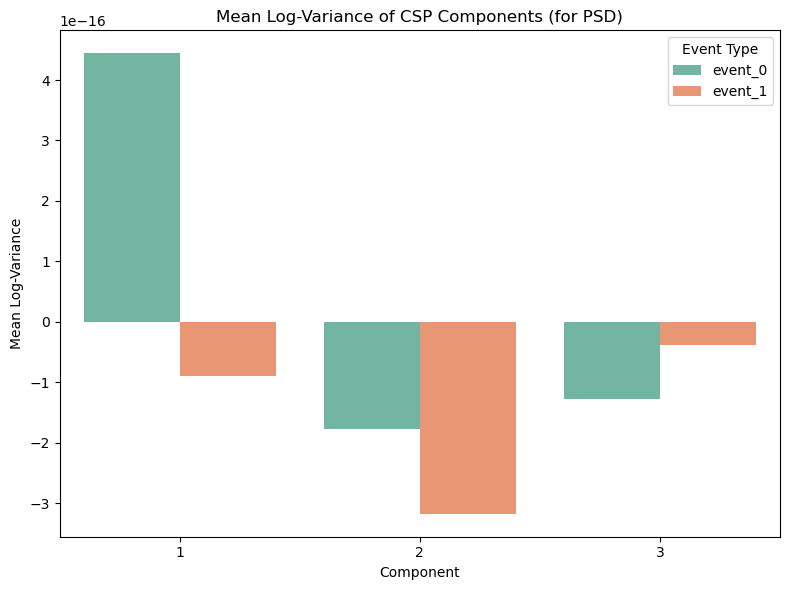

,Event Type,Epoch,PSD comp 1,PSD comp 2,PSD comp 3
0,0,0,1.229432,2.083045,1.696773
1,0,1,-0.418667,0.154135,0.025364
2,0,2,-0.290835,0.560507,-0.031691
3,0,3,0.092885,0.878147,-0.445564
4,0,4,-0.690826,1.087001,-0.595720


In [9]:

trials_logvar_normalized_psd = {
    'event_0': normalize_features(trials_logvar_csp_psd['event_0']),
    'event_1': normalize_features(trials_logvar_csp_psd['event_1'])
}

data_psd = [
    [event_type, comp + 1, np.mean(trials_logvar_normalized_psd[event_type][comp, :])]
    for event_type in ['event_0', 'event_1']
    for comp in range(3)  
]

df_psd = pd.DataFrame(data_psd, columns=['Event Type', 'Component', 'Log-Variance'])


plt.figure(figsize=(8, 6))
sns.barplot(x='Component', y='Log-Variance', hue='Event Type', data=df_psd, palette='Set2')

plt.title('Mean Log-Variance of CSP Components (for PSD)')
plt.xlabel('Component')
plt.ylabel('Mean Log-Variance')
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

data = [
    [event_type, comp + 1, epoch, logvar_data[comp, epoch]]
    for event_type in [0, 1]
    for epoch in range(trials_logvar_normalized_psd[f'event_{event_type}'].shape[1])
    for comp in range(3)
    for logvar_data in [trials_logvar_normalized_psd[f'event_{event_type}']]
]

df = pd.DataFrame(data, columns=['Event Type', 'Component', 'Epoch', 'Log-Variance'])
psd_df_pivoted = df.pivot_table(index=['Event Type', 'Epoch'], columns='Component', values='Log-Variance').reset_index()
psd_df_pivoted.columns = ['Event Type', 'Epoch', 'PSD comp 1', 'PSD comp 2', 'PSD comp 3']
psd_df_pivoted['Epoch'] = range(len(psd_df_pivoted))

psd_df_pivoted.head()



La derniere feature qu'on va etudier est l'amplitude par le temps qui a montré des chagements significatifs principalement à l'onde beta.

In [10]:
epochs = mne.read_epochs(file_path)


sample_rate = epochs.info['sfreq']
win_start, win_end = int(0 * sample_rate), int(4 * sample_rate) 
event_codes = epochs.events[:, 2]  

trials = {f"event_{code}": [] for code in np.unique(event_codes)}

for code in np.unique(event_codes):
    event_indices = np.where(event_codes == code)[0]
    sliced_epochs = [
        epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
    ]
    trials[f"event_{code}"] = np.transpose(np.array(sliced_epochs), (1, 2, 0))


trials_filt = {
    'event_0': bandpass(trials['event_0'], lo=8, hi=30, sample_rate=sample_rate),
    'event_1': bandpass(trials['event_1'], lo=8, hi=30, sample_rate=sample_rate),
}
cl1 = 'event_0'
cl2 = 'event_1'


def calculate_amplitude_by_time_for_beta(trials, sample_rate, beta_range=(13, 30)):

    min_freq, max_freq = beta_range
    
    n_channels, n_timepoints, n_epochs = trials.shape
    amplitudes = np.zeros((n_channels, n_timepoints, n_epochs))
    
    for trial_idx in range(n_epochs):
        for ch_idx in range(n_channels):
            eeg_data = trials[ch_idx, :, trial_idx]
            
            amplitude_time_series = amp_by_time(eeg_data, fs=sample_rate, freqs=np.arange(min_freq, max_freq+1))
            
            amplitudes[ch_idx, :, trial_idx] = amplitude_time_series
    
    return amplitudes

amplitude_event_0 = calculate_amplitude_by_time_for_beta(trials_filt['event_0'], sample_rate=1000)
amplitude_event_1 = calculate_amplitude_by_time_for_beta(trials_filt['event_1'], sample_rate=1000)



Reading C:\Users\phili\EEG_project\EEG_proj_data\ucsd-neural-data-challenge\data\epoch_propre\screening_epochs_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 3) active
    Found the data of interest:
        t =       0.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
2240 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\phili\AppData\Local\Temp\ipykernel_19680\1801744463.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
C:\Users\phili\AppData\Local\Temp\ipykernel_19680\1801744463.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
C:\Users\phili\AppData\Local\Temp\ipykernel_19680\1801744463.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data()[idx][:, win_start:win_end] for idx in event_indices
C:\Users\phili\AppData\Local\Temp\ipykernel_19680\1801744463.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of co

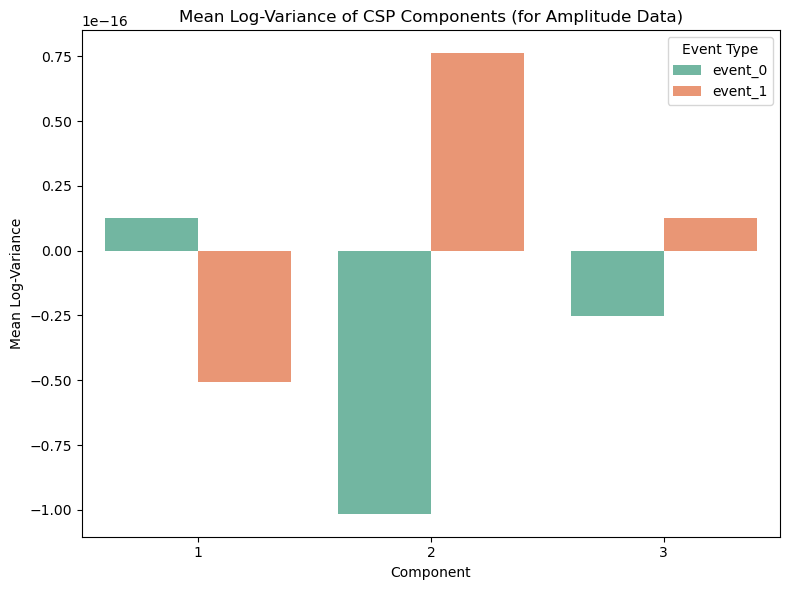

,Event Type,Epoch,amp comp 1,amp comp 2,amp comp 3
0,0,0,0.730880,0.470949,2.415468
1,0,1,-0.245221,-0.698723,0.200357
2,0,2,0.160827,-0.343081,0.343159
3,0,3,0.642545,-0.404505,0.144481
4,0,4,0.351727,-0.474222,0.353931


In [11]:

def batch_cov(trials, batch_size=50):
    n_trials = trials.shape[2]
    n_channels = trials.shape[0]

    cov_sum = np.zeros((n_channels, n_channels))

    for start in range(0, n_trials, batch_size):
        end = min(start + batch_size, n_trials)
        batch = trials[:, :, start:end]
        for i in range(batch.shape[2]):
            cov_sum += np.cov(batch[:, :, i], rowvar=True)

    return cov_sum / n_trials

def whitening(sigma):
    U, l, _ = linalg.svd(sigma)
    return U @ np.diag(l ** -0.5)

def csp(trials_r, trials_l):
    cov_r = batch_cov(trials_r)
    cov_l = batch_cov(trials_l)
    P = whitening(cov_r + cov_l)  
    B, _, _ = linalg.svd(P.T @ cov_l @ P)
    W = P @ B
    return W

def apply_csp(W, trials):
    n_trials = trials.shape[2]
    trials_csp = np.zeros((W.shape[0], trials.shape[1], n_trials))
    for i in range(n_trials):
        trials_csp[:, :, i] = W.T @ trials[:, :, i]
    return trials_csp

def logvar_amp(amplitude_data):
    return np.log(np.var(amplitude_data, axis=1))

W = csp(amplitude_event_0, amplitude_event_1) 

trials_csp_event_0 = apply_csp(W, amplitude_event_0)  
trials_csp_event_1 = apply_csp(W, amplitude_event_1)  

logvar_csp_event_0 = logvar_amp(trials_csp_event_0)
logvar_csp_event_1 = logvar_amp(trials_csp_event_1)  

logvar_csp_event_0_normalized = normalize_features(logvar_csp_event_0)
logvar_csp_event_1_normalized = normalize_features(logvar_csp_event_1)

data_amp = []
for event_type in ['event_0', 'event_1']:
    for comp in range(3): 
        logvar_data = np.mean(logvar_csp_event_0_normalized[comp, :]) if event_type == 'event_0' \
            else np.mean(logvar_csp_event_1_normalized[comp, :])
        data_amp.append([event_type, comp + 1, logvar_data])

df_amp = pd.DataFrame(data_amp, columns=['Event Type', 'Component', 'Log-Variance'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Component', y='Log-Variance', hue='Event Type', data=df_amp, palette='Set2')
plt.title('Mean Log-Variance of CSP Components (for Amplitude Data)')
plt.xlabel('Component')
plt.ylabel('Mean Log-Variance')
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

data_csp = [
    [event_type, comp + 1, epoch, logvar_csp_event_0_normalized[comp, epoch] if event_type == 0 else logvar_csp_event_1_normalized[comp, epoch]]
    for event_type in [0, 1] 
    for epoch in range(logvar_csp_event_0_normalized.shape[1]) 
    for comp in range(3)  
]

df_csp = pd.DataFrame(data_csp, columns=['Event Type', 'Component', 'Epoch', 'Log-Variance'])

amp_df_csp_pivoted = df_csp.pivot_table(index=['Event Type', 'Epoch'], columns='Component', values='Log-Variance').reset_index()

amp_df_csp_pivoted.columns = ['Event Type', 'Epoch', 'amp comp 1', 'amp comp 2', 'amp comp 3']

amp_df_csp_pivoted['Epoch'] = range(len(amp_df_csp_pivoted))

amp_df_csp_pivoted.head()


In [12]:
# Merge the DataFrames based on 'Event Type' and 'Epoch'
csp_df = pd.merge(amp_df_csp_pivoted, eeg_df_pivoted, on=['Event Type', 'Epoch'], how='outer')
csp_df = pd.merge(csp_df, psd_df_pivoted, on=['Event Type', 'Epoch'], how='outer')

print(csp_df.shape)
print(csp_df.columns)

null_counts = csp_df.isnull().sum()
print(null_counts)



(2240, 11)
Index(['Event Type', 'Epoch', 'amp comp 1', 'amp comp 2', 'amp comp 3',
       'eeg comp 1', 'eeg comp 2', 'eeg comp 3', 'PSD comp 1', 'PSD comp 2',
       'PSD comp 3'],
      dtype='object')
Event Type    0
Epoch         0
amp comp 1    0
amp comp 2    0
amp comp 3    0
eeg comp 1    0
eeg comp 2    0
eeg comp 3    0
PSD comp 1    0
PSD comp 2    0
PSD comp 3    0
dtype: int64


In [13]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



On passe à la pase de modelling on va essayer différent modeles sur notre dataset.

In [20]:


X = csp_df[['amp comp 1', 'amp comp 3', 
            'eeg comp 1', 'eeg comp 2', 'eeg comp 3', 
            'PSD comp 1','PSD comp 2', 'PSD comp 3']]

y = csp_df['Event Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5959821428571429

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.65      0.62       226
           1       0.60      0.54      0.57       222

    accuracy                           0.60       448
   macro avg       0.60      0.60      0.59       448
weighted avg       0.60      0.60      0.59       448



In [21]:


X = csp_df[['amp comp 1','amp comp 2', 'amp comp 3', 
            'eeg comp 1', 'eeg comp 2', 'eeg comp 3', 
            'PSD comp 1','PSD comp 2', 'PSD comp 3']]

y = csp_df['Event Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='rbf', random_state=42)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5691964285714286

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.52      0.55       226
           1       0.56      0.62      0.59       222

    accuracy                           0.57       448
   macro avg       0.57      0.57      0.57       448
weighted avg       0.57      0.57      0.57       448



c:\Users\phili\anaconda3_1\envs\eeg_analysis\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       226
           1       0.56      0.59      0.58       222

    accuracy                           0.57       448
   macro avg       0.57      0.57      0.57       448
weighted avg       0.57      0.57      0.57       448

Confusion Matrix:
[[122 104]
 [ 90 132]]
Test Accuracy: 0.57


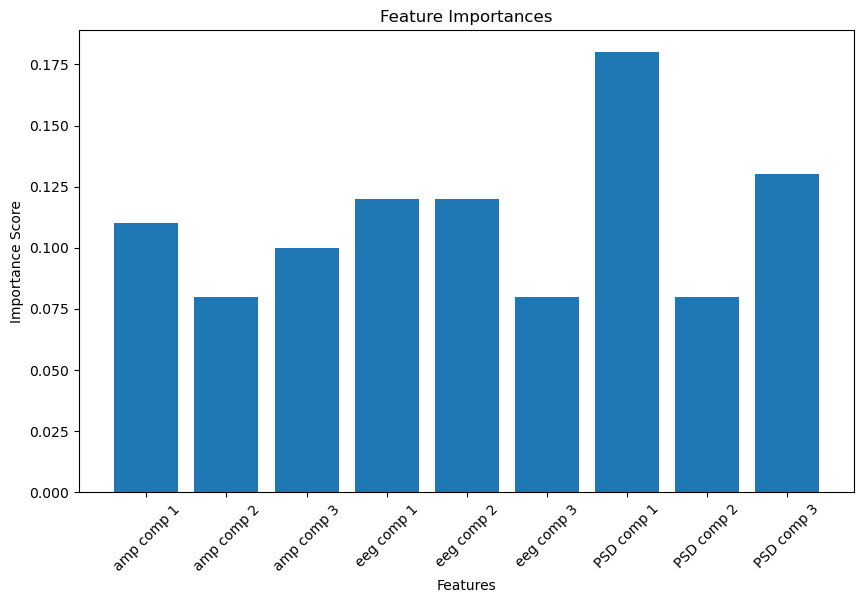

In [ ]:


X = csp_df[['amp comp 1', 'amp comp 2', 'amp comp 3', 
            'eeg comp 1', 'eeg comp 2', 'eeg comp 3', 
            'PSD comp 1', 'PSD comp 2', 'PSD comp 3']]  
y = csp_df['Event Type']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_estimator = DecisionTreeClassifier(max_depth=1)  

ada_boost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)

ada_boost.fit(X_train_scaled, y_train)

y_pred = ada_boost.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")

if hasattr(ada_boost, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    plt.bar(X.columns, ada_boost.feature_importances_)
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45)
    plt.show()


Epoch 1/100
28/28 [==============================] - 2s 24ms/step - loss: 0.6957 - accuracy: 0.5128 - val_loss: 0.6952 - val_accuracy: 0.5424
Epoch 2/100
28/28 [==============================] - 0s 8ms/step - loss: 0.6938 - accuracy: 0.5307 - val_loss: 0.6925 - val_accuracy: 0.5134
Epoch 3/100
28/28 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.5279 - val_loss: 0.6910 - val_accuracy: 0.5112
Epoch 4/100
28/28 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5352 - val_loss: 0.6907 - val_accuracy: 0.5335
Epoch 5/100
28/28 [==============================] - 0s 7ms/step - loss: 0.6890 - accuracy: 0.5179 - val_loss: 0.6902 - val_accuracy: 0.5179
Epoch 6/100
28/28 [==============================] - 0s 9ms/step - loss: 0.6872 - accuracy: 0.5491 - val_loss: 0.6871 - val_accuracy: 0.5513
Epoch 7/100
28/28 [==============================] - 0s 7ms/step - loss: 0.6811 - accuracy: 0.5619 - val_loss: 0.6887 - val_accuracy: 0.5134
Epoch 8/100


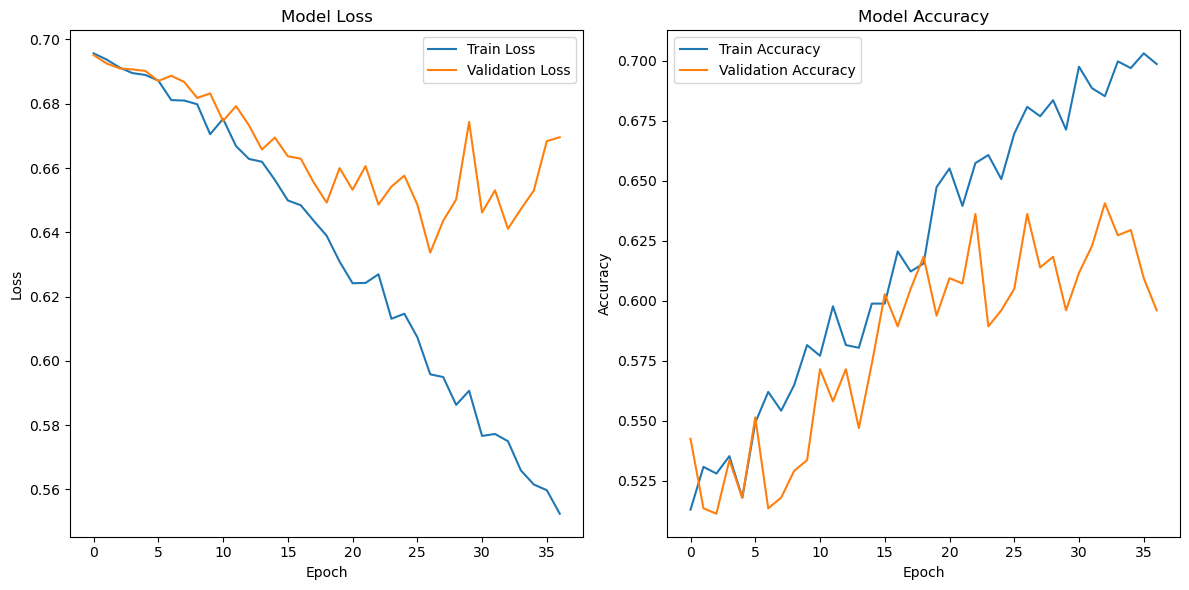

14/14 [==============================] - 0s 7ms/step - loss: 0.6337 - accuracy: 0.6362
Test accuracy: 0.6361607313156128


In [24]:
X = csp_df[['amp comp 1', 'amp comp 2', 'amp comp 3', 
            'eeg comp 1', 'eeg comp 2', 'eeg comp 3', 
            'PSD comp 1', 'PSD comp 2', 'PSD comp 3']] 
y = csp_df['Event Type'] 

y = pd.get_dummies(y).iloc[:, 1].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

model = Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))

model.add(Conv1D(128, kernel_size=3, activation='relu'))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, 
                    validation_data=(X_test_scaled, y_test), 
                    callbacks=[early_stopping], verbose=1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc}")
